In [71]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from scipy import stats
from folium.plugins import MarkerCluster
import warnings
import folium
import zipfile

In [72]:
#zf = zipfile.ZipFile('chicago-food-inspections.zip')
#dblp = pd.read_csv(zf.open('chicago-food-inspections/food-inspections.csv'))

In [73]:
#dblp = dblp.drop(['AKA Name', 'Address','City','State','Location','Historical Wards 2003-2015','Zip Codes','Community Areas','Census Tracts','Wards'], axis=1)

In [74]:
#dblp.to_csv(r'food_inspections.csv')

In [75]:
zf = zipfile.ZipFile('chicago_dropped.zip')
df = pd.read_csv(zf.open('chicago_dropped/food_inspections.csv'))

In [76]:
print(df.loc[7330])

Unnamed: 0                                 7330
Inspection ID                           2291008
DBA Name           SUPERMERCADO EL PARAISO INC.
License #                           2.67041e+06
Facility Type                     Grocery Store
Risk                                        All
Zip                                       60632
Inspection Date         2019-06-06T00:00:00.000
Inspection Type                         License
Results                               Not Ready
Violations                                  NaN
Latitude                                41.8153
Longitude                               -87.702
Name: 7330, dtype: object


In [77]:
df = df[df.Risk.str.contains("[1-3]",na=False)]
df['Risk'] = df.Risk.apply(lambda x: int(x.strip('Risk')[1]))
df.head()



,Unnamed: 0,Inspection ID,DBA Name,License #,Facility Type,Risk,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
0,0,2345787,"CARNICERIA LEON GUANAJUATO, INC.",1821637.0,Grocery Store,1,60639.0,2019-11-18T00:00:00.000,Canvass,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.916960,-87.733945
1,1,2345790,AMSTAR FUEL & MINI MART,1426374.0,Grocery Store,2,60651.0,2019-11-18T00:00:00.000,Canvass,Pass,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...",41.895304,-87.721129
2,2,2345766,ROJO GUSANO,1305286.0,Restaurant,1,60625.0,2019-11-18T00:00:00.000,Canvass,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.968390,-87.724448
3,3,2345702,LAKESIDE FOOD WINE SPIRITS LLC,2694148.0,Grocery Store,3,60614.0,2019-11-15T00:00:00.000,License Re-Inspection,Pass w/ Conditions,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.929210,-87.648746
4,4,2345678,"NEW KNOWLEDGE LEARNING CENTER, INC.",2215898.0,Children's Services Facility,1,60652.0,2019-11-15T00:00:00.000,License,Pass,"53. TOILET FACILITIES: PROPERLY CONSTRUCTED, S...",41.739458,-87.702257


In [78]:
df['Facility Type'] = df['Facility Type'].str.lower()
df['Facility Type'] = df['Facility Type'].apply(lambda x: str(x).replace(r"[a-zA-Z]+",""))

In [79]:
grouped_fac = df.groupby('Facility Type')

#facility vs average risk
grouped_fac_risk_mean = grouped_fac['Risk'].mean()
grouped_fac_risk_mean.head()

Facility Type
(convenience store)                 3.0
(gas station)                       3.0
1005 nursing home                   1.0
1023                                1.0
1023 childern's service facility    1.0
Name: Risk, dtype: float64

## Facility Type vs. Average Risk
We realized that this plot is not meaningful due to the number of Facility Types(438 in total). 

In [80]:
#inspection vs facility type
grouped_fac.count()[grouped_fac.count().columns[0]].sort_values()

Facility Type
(convenience store)                  1
hooka bar                            1
incubator                            1
internet cafe                        1
kids cafe                            1
                                 ...  
children's services facility      3085
nan                               4698
school                           12135
grocery store                    24956
restaurant                      130672
Name: Unnamed: 0, Length: 438, dtype: int64

In [81]:
#out of business facilities

df_oob = df[df.Results.str.contains("Out of Business",na=False)]
df_oob
#grouped by the facilities
df_oob_unique = df_oob.groupby(['Latitude','Longitude','DBA Name']).count()

In [115]:
mapp = folium.Map(
    location=[41.8781, -87.6298],
    zoom_start=5
)


marker_cluster = MarkerCluster().add_to(mapp)
ranges = 0
for i in df_oob_unique.index:
    if ranges == 6000:
        break
    folium.Marker([(i[0]), (i[1])]).add_to(marker_cluster)
        
    ranges = ranges + 1
    
 
 




mapp


In [148]:
df_avg_risk_score = df.groupby(['Latitude','Longitude','DBA Name'])['Risk'].mean()

In [164]:
int(21 / 5) + (21 % 5 > 0)
map_riskli = folium.Map(
    location=[41.8781, -87.6298],
    zoom_start=5
)


ranges = 0
for i in df_avg_risk_score.index:
    if ranges == 1000:
        break
    if(round(df_avg_risk_score[i]) == 1):
        folium.Marker([(i[0]), (i[1])],icon=folium.Icon(color='red', )).add_to(map_riskli)
    elif(round(df_avg_risk_score[i]) == 2):
        folium.Marker([(i[0]), (i[1])],icon=folium.Icon(color='orange', )).add_to(map_riskli)
    elif(round(df_avg_risk_score[i]) == 3):
        folium.Marker([(i[0]), (i[1])],icon=folium.Icon(color='green', )).add_to(map_riskli)
    
        
    ranges = ranges + 1

map_riskli

We observed that the number of risk 3 facilities are lower than the others. Hence, we have decided to plot **average risk scores vs number of facilities

In [162]:
#Grouped by risk scores and number of facilities
df_avg_risk_score1 = pd.DataFrame(df_avg_risk_score).apply(lambda x: round(x)).reset_index()
df_avg_risk_score1 = pd.DataFrame(df_avg_risk_score1.groupby('Risk').count()['Latitude']).rename(columns={'Latitude':'Counts'})
df_avg_risk_score1



,Counts
Risk,
1.0,16509
2.0,7394
3.0,7370


<BarContainer object of 3 artists>

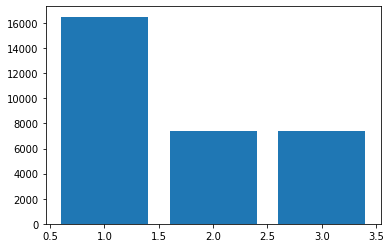

In [163]:
plt.bar(df_avg_risk_score1.index,df_avg_risk_score1['Counts'])

Her yer pislik içinde şikago sıkıntı (imamhatipler kapatılsın)